<a href="https://colab.research.google.com/github/Mohammad-debug/Pneumonia-Caps/blob/main/Copy_of_Copy_of_BostonHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geppy

     |████████████████████████████████| 163kB 11.8MB/s 
  Created wheel for geppy: filename=geppy-0.1.2-cp37-none-any.whl size=31772 sha256=bf5790904af878c24e0135b954125d3be7df74c989ef01adee332b8607e065c3
  Stored in directory: /root/.cache/pip/wheels/dd/72/b0/626973c605f8c2d7797cf7defc0e3cda716a531999cb5c8577
Successfully built geppy


In [77]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

import operator 
import math
import datetime

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

In [222]:


import os

#doublecheck the data is there
print(os.listdir("/content"))
import pandas as pd

# read in the data to pandas
PowerPlantData1 = pd.read_csv("/content/BOSTON.csv")



['.config', 'numerical_expression_tree.png', 'drive', 'BOSTON.csv', 'numerical_expression_tree', 'sample_data']


### we must normalize our data for neural networks to perform optimally

In [223]:
from sklearn.preprocessing import MinMaxScaler

In [224]:
# Lets build our function which will perform the normaliztion
def rescale(X):
    mean = X.mean()
    std = X.std()
    scaled_X = [(i - mean)/std for i in X]
    return pd.Series(scaled_X)

# We will build a new dataframe
PowerPlantData = pd.DataFrame(columns=PowerPlantData1.columns)
for i in PowerPlantData1.columns:
    PowerPlantData[i] = rescale(PowerPlantData1[i])

In [193]:
PowerPlantData.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [194]:
PowerPlantData.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [225]:
msk = np.random.rand(len(PowerPlantData)) < 0.8
train = PowerPlantData[msk]
holdout = PowerPlantData[~msk]

In [226]:
# check the number of records we'll validate our MSE with
holdout.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.037887,-0.068990,-0.001973,0.055763,0.101946,-0.039739,-0.032759,-0.066135,0.077271,0.027381,0.024816,0.021964,0.054872,0.001567
std,0.889994,0.885311,1.002512,1.093230,1.057197,1.053084,1.016662,0.947400,1.040376,1.060486,0.985319,0.969997,1.100336,1.038911
min,-0.418589,-0.487240,-1.445520,-0.272329,-1.334986,-3.055198,-2.333128,-1.262302,-0.981871,-1.306758,-2.704703,-3.804749,-1.369973,-1.688880
25%,-0.411778,-0.487240,-0.902545,-0.272329,-0.845245,-0.580522,-0.750471,-0.813321,-0.637331,-0.820218,-0.395176,0.220916,-0.843091,-0.636919
50%,-0.388192,-0.487240,-0.210890,-0.272329,-0.118185,-0.168846,0.038193,-0.327392,-0.522484,-0.523547,0.297683,0.374019,-0.188076,-0.134043
75%,0.143123,-0.353249,1.014995,-0.272329,0.874240,0.616788,0.976064,0.537221,1.659603,1.529413,0.805778,0.428677,0.711300,0.466690
max,4.898257,3.586088,2.420170,3.664771,2.729645,3.007848,1.116390,3.284050,1.659603,1.796416,1.267684,0.440616,3.545262,2.986505


In [227]:
# check the number of records we'll train our algorithm with
train.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,-0.010281,0.018721,0.000535,-0.015132,-0.027664,0.010783,0.008889,0.017946,-0.020968,-0.007430,-0.006734,-0.005960,-0.014890,-0.000425
std,1.028620,1.029150,1.000581,0.974087,0.983469,0.986204,0.996540,1.014206,0.989065,0.984210,1.005068,1.009100,0.971946,0.990523
min,-0.419367,-0.487240,-1.556302,-0.272329,-1.464433,-3.876413,-2.222999,-1.265817,-0.981871,-1.312691,-2.704703,-3.903331,-1.529613,-1.906340
25%,-0.410480,-0.487240,-0.866833,-0.272329,-0.918599,-0.564154,-0.853495,-0.803906,-0.637331,-0.737150,-0.672319,0.197557,-0.774123,-0.579835
50%,-0.390605,-0.487240,-0.210890,-0.272329,-0.195854,-0.106223,0.363251,-0.261737,-0.522484,-0.464213,0.251492,0.384972,-0.169171,-0.150352
75%,-0.045543,0.048724,1.014995,-0.272329,0.598087,0.451335,0.894356,0.708672,1.200216,1.529413,0.805778,0.433715,0.548509,0.268258
max,9.924110,3.800473,2.420170,3.664771,2.729645,3.551530,1.116390,3.956602,1.659603,1.796416,1.637208,0.440616,3.097150,2.986505


In [228]:


# copy and convert our pandas dataframe into numpy variables.
# I will leave the target at Y, as I can't see where to set that in the code, but it's in there somehow!

# NOTE: I'm only feeding in the TRAIN values to the algorithms. Later I will independely check
# the MSE myself using a holdout test dataset

#X1 = train['X1 transaction date'].values
crim = train['crim'].values
zn = train['zn'].values
indus = train['indus'].values
chas = train['chas'].values
nox = train['nox'].values
rm = train['rm'].values#
age = train['age'].values
dis = train['dis'].values
rad = train['rad'].values
tax = train['tax'].values
ptratio = train['ptratio'].values
black = train['black'].values
lstat = train['lstat'].values#
Y = train['medv'].values



In [229]:


def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2



In [230]:
pset = gep.PrimitiveSet('Main', input_names=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat'])

In [231]:
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_function(math.sin, 1)        # I tested adding my own functions
pset.add_function(math.cos, 1)
pset.add_function(math.tan, 1)
pset.add_rnc_terminal()

In [232]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [233]:
h = 20        # head length
n_genes = 2    # number of genes in a chromosome
r = 10         # length of the RNC array
enable_ls = True # whether to apply the linear scaling technique

In [234]:
toolbox = gep.Toolbox()
toolbox.register('rnc_gen', random.randint, a=-10, b=10)   # each RNC is random integer within [-5, 5]
toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h, rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [238]:
# as a test I'm going to try and accelerate the fitness function
from numba import jit

@jit
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    
    # below call the individual as a function over the inputs
    
    # Yp = np.array(list(map(func, X)))
    Yp = np.array(list(map(func, rm,age,dis,rad,tax,ptratio,black,lstat))) 
    
    # return the MSE as we are evaluating on it anyway - then the stats are more fun to watch...
    return np.mean((Y - Yp) ** 2),

In [236]:
from numba import jit

@jit
def evaluate_ls(individual):
    """
    First apply linear scaling (ls) to the individual 
    and then evaluate its fitness: MSE (mean squared error)
    """
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat)))
    
    # special cases which cannot be handled by np.linalg.lstsq: (1) individual has only a terminal 
    #  (2) individual returns the same value for all test cases, like 'x - x + 10'. np.linalg.lstsq will fail in such cases.
    # That is, the predicated value for all the examples remains identical, which may happen in the evolution.
    if isinstance(Yp, np.ndarray):
        Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
        (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Y)   
        # residuals is the sum of squared errors
        if residuals.size > 0:
            return residuals[0] / len(Y),   # MSE
    
    # regarding the above special cases, the optimal linear scaling w.r.t LSM is just the mean of true target values
    individual.a = 0
    individual.b = np.mean(Y)
    return np.mean((Y - individual.b) ** 2),

In [239]:
if enable_ls:
    toolbox.register('evaluate', evaluate_ls)
else:
    toolbox.register('evaluate', evaluate)

In [240]:


toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.3)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
# 2. Dc-specific operators
toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.05, pb=1)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)
toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)
# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.5p')
toolbox.pbs['mut_rnc_array_dc'] = 1  # we can also give the probability via the pbs property



In [241]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [242]:


# size of population and number of generations
n_pop = 180
n_gen = 100

#100 3000

champs = 3

pop = toolbox.population(n=n_pop) # 
hof = tools.HallOfFame(champs) 

In [243]:
startDT = datetime.datetime.now()
print (str(startDT))


2021-03-16 17:46:01.411545


In [244]:


# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)



<ipython-input-236-701e9fb88ec2>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "evaluate_ls" failed type inference due to: Untyped global name 'toolbox': cannot determine Numba type of <class 'geppy.tools.toolbox.Toolbox'>

File "<ipython-input-236-701e9fb88ec2>", line 9:
def evaluate_ls(individual):
    <source elided>
    """
    func = toolbox.compile(individual)
    ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "evaluate_ls" was compiled in object mode without forceobj=True.

File "<ipython-input-236-701e9fb88ec2>", line 4:
@jit
def evaluate_ls(individual):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/

gen	nevals	avg     	std    	min     	max     
0  	180   	0.868695	0.13573	0.460467	0.978662
1  	179   	0.762781	0.156587	0.453746	0.978657
2  	179   	0.684782	0.177611	0.33899 	0.978648
3  	179   	0.622059	0.197075	0.33899 	0.978637
4  	179   	0.559743	0.181809	0.33899 	0.97867 
5  	179   	0.540678	0.184926	0.326123	0.978442
6  	179   	0.541739	0.202366	0.296383	0.978665
7  	179   	0.529559	0.206951	0.296383	0.978657
8  	179   	0.490479	0.198688	0.290418	0.978654
9  	179   	0.483662	0.219127	0.290418	0.978667
10 	179   	0.492413	0.231517	0.277406	0.978669
11 	179   	0.509979	0.250796	0.270968	0.97867 
12 	179   	0.458041	0.21693 	0.270968	0.978449
13 	179   	0.495616	0.25262 	0.270968	0.97867 
14 	179   	0.476088	0.239071	0.270968	0.978483
15 	179   	0.492949	0.242744	0.270968	0.978618
16 	179   	0.43052 	0.209759	0.270968	0.978669
17 	179   	0.463416	0.242795	0.270968	0.978665
18 	179   	0.441586	0.237435	0.270968	0.97867 
19 	179   	0.445104	0.243687	0.270968	0.978669
20 	179   	0.46

In [245]:
print ("Evolution times were:\n\nStarted:\t", startDT, "\nEnded:   \t", str(datetime.datetime.now()))

Evolution times were:

Started:	 2021-03-16 17:46:01.411545 
Ended:   	 2021-03-16 17:46:50.438019


In [248]:


print(hof[0])



add(
	mul(rm, lstat),
	add(ptratio, add(sub(lstat, rm), sub(lstat, sin(ptratio))))
)


In [249]:


# print the best symbolic regression we found:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)

if enable_ls:
    symplified_best = best_ind.a * symplified_best + best_ind.b

key= '''
#Given training examples of

    AT = Atmospheric Temperature (C)
    V = Exhaust Vacuum Speed
    AP = Atmospheric Pressure
    RH = Relative Humidity

we trained a computer using Genetic Algorithms to predict the 

    PE = Power Output

Our symbolic regression process found the following equation offers our best prediction:

'''

print('\n', key,'\t', str(symplified_best), '\n\nwhich formally is presented as:\n\n')

from sympy import *
init_printing()
symplified_best


 
#Given training examples of

    AT = Atmospheric Temperature (C)
    V = Exhaust Vacuum Speed
    AP = Atmospheric Pressure
    RH = Relative Humidity

we trained a computer using Genetic Algorithms to predict the 

    PE = Power Output

Our symbolic regression process found the following equation offers our best prediction:

 	 -0.289835688960316*lstat*rm - 0.579671377920632*lstat - 0.289835688960316*ptratio + 0.289835688960316*rm + 0.289835688960316*sin(ptratio) - 0.208269336281887 

which formally is presented as:




In [250]:

# we want to use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'numerical_expression_tree.png')



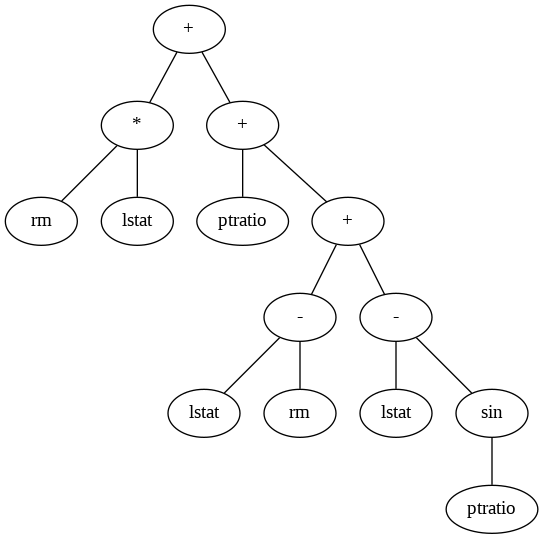

In [251]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='numerical_expression_tree.png')

In [253]:
crim = train['crim'].values
zn = train['zn'].values
indus = train['indus'].values
chas = train['chas'].values
nox = train['nox'].values
rm = train['rm'].values#
age = train['age'].values
dis = train['dis'].values
rad = train['rad'].values
tax = train['tax'].values
ptratio = train['ptratio'].values
black = train['black'].values
lstat = train['lstat'].values#
Y = train['medv'].values
n=indus.size
print(n)
arr=np.zeros(n)
print(arr.size)
for i in range(0,n):
    arr[i]= -0.289835688960316*lstat[i]*rm[i] - 0.579671377920632*lstat[i] - 0.289835688960316*ptratio[i] + 0.289835688960316*rm[i] + 0.289835688960316*sin(ptratio[i]) - 0.208269336281887


398
398


In [254]:

#Train
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("Mean squared error: %.7f" % mean_squared_error(Y, arr))
print("R2 score : %.7f" % r2_score(Y, arr))
print("MAE : %.7f" % mean_absolute_error(Y, arr))
a=np.sqrt(mean_squared_error(Y, arr))
print("RMSE  : %.7f" % a)

Mean squared error: 0.2402589
R2 score : 0.7545047
MAE : 0.3240595
RMSE  : 0.4901622


In [255]:
#test

crim = holdout['crim'].values
zn = holdout['zn'].values
indus = holdout['indus'].values
chas = holdout['chas'].values
nox = holdout['nox'].values
rm = holdout['rm'].values
age = holdout['age'].values
dis = holdout['dis'].values
rad = holdout['rad'].values
tax = holdout['tax'].values
ptratio = holdout['ptratio'].values
black = holdout['black'].values
lstat = holdout['lstat'].values
Y2 = holdout['medv'].values

n=indus.size
print(n)
arr2=np.zeros(n)
print(arr2.size)
for i in range(0,n):
     arr2[i]=   -0.289835688960316*lstat[i]*rm[i] - 0.579671377920632*lstat[i] - 0.289835688960316*ptratio[i] + 0.289835688960316*rm[i] + 0.289835688960316*sin(ptratio[i]) - 0.208269336281887
     #-0.776168824557747*lstat[i] - 0.776168824557747*ptratio[i] + 2.32850647367324*rm[i] - 0.776168824557747*(dis[i] + 8)*cos(rm[i]) - 0.776168824557747*cos(tan(zn[i])) + 40.2676568980662

print("Mean squared error: %.7f" % mean_squared_error(Y2, arr2))
print("R2 score : %.7f" % r2_score(Y2, arr2))
print("MAE : %.7f" % mean_absolute_error(Y2, arr2))
a=np.sqrt(mean_squared_error(Y2, arr2))
print("RMSE  : %.7f" % a)
#-0.507097948563564*sin(sin(2*lstat[i])) - 0.507097948563564*cos(rm[i]*tan(cos(ptratio[i]))) + 1.0507016967642
#-0.220643443514503*sin(lstat[i] - sin(rm[i] - tan(ptratio[i])) + tan(dis[i] + lstat[i])) - 0.220643443514503*tan(sin(2*lstat[i] - tan(rm[i]))) + 0.549942691732136

108
108
Mean squared error: 0.2843724
R2 score : 0.7340679
MAE : 0.3274162
RMSE  : 0.5332658


Extras




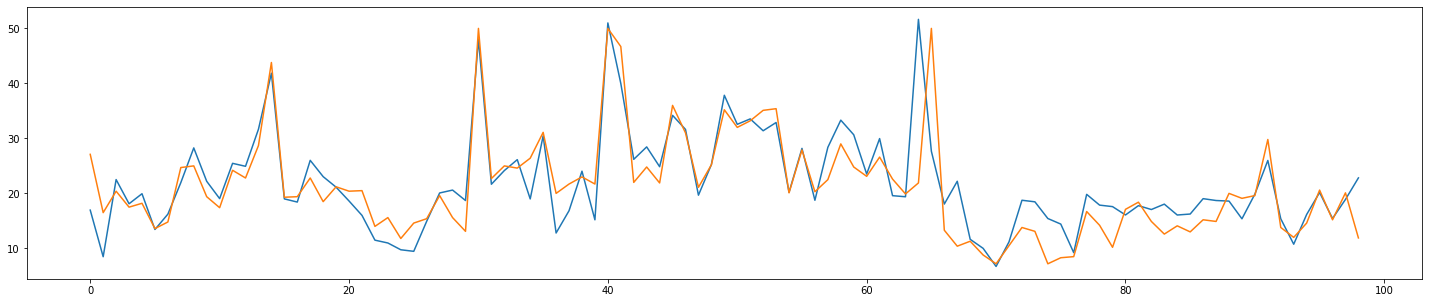

In [ ]:
#Test
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [25, 5]
plotlen=200
pyplot.plot(arr2)# predictions are in blue
pyplot.plot(Y2) # actual values are in orange
pyplot.show()

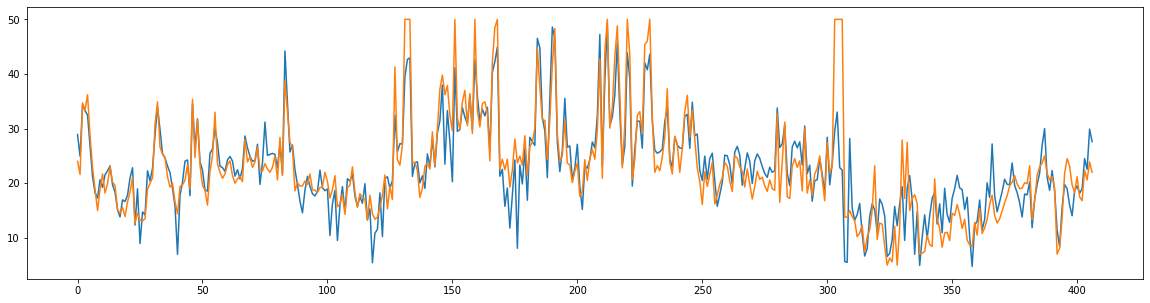

In [ ]:
#Train
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [20, 5]
plotlen=200
pyplot.plot(arr)# predictions are in blue
pyplot.plot(Y) # actual values are in orange
pyplot.show()

In [ ]:
def CalculateBestModelOutput( crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat, model):
    # pass in a string view of the "model" as str(symplified_best) 
    # this string view of the equation may reference any of the other inputs, AT, V, AP, RH we registered
    # we then use eval of this string to calculate the answer for these inputs
    return eval(model) 
Ypredict = CalculateBestModelOutput( str(symplified_best))
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(Y, Ypredict))
print("R2 score : %.2f" % r2_score(Y, Ypredict))


TypeError: ignored

In [ ]:
#test
X1_ = holdout['X1 transaction date'].values
X2_ = holdout['X2 house age'].values
X3_ = holdout['X3 distance to the nearest MRT station'].values
X4_ = holdout['X4 number of convenience stores'].values
X5_ = holdout['X5 latitude'].values
X6_ = holdout['X6 longitude'].values
Y_ = holdout['Y house price of unit area'].values
n=X1_.size
print("Total test data = "+str(n))


def CalculateBestModelOutput(X1_,X2_,X3_,X4_,X5_,X6_, model):
    # pass in a string view of the "model" as str(symplified_best)
    # this string view of the equation may reference any of the other inputs, AT, V, AP, RH we registered
    # we then use eval of this string to calculate the answer for these inputs
    return eval(model) 
    
Ypredict = CalculateBestModelOutput(X1_,X2_,X3_,X4_,X5_,X6_, str(symplified_best))
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(Y_, Ypredict))
print("R2 score : %.2f" % r2_score(Y_, Ypredict))


Total test data = 77


AttributeError: ignored